In [92]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
import os, sys
sys.path.append(os.getenv('PYTHONPATH'))
from config.settings import *
import torch
import torch.nn as nn

## Related work
- IEEE International Symposium on Biomedical Imaging 2021 challenge: Large-scale 3D Mitochondria Instance Segmentation
<img src="figures/isbi.png" style="width:80%"/>

## Multilayer perceptron
$\hat{y} = \mathbf{w}^\top\mathbf{x} + b$

## Softmax
$$\mathrm{softmax}(\mathbf{X}_{ij}) = \frac{\mathrm{exp}(\mathbf{X}_{ij})}{\sum_k \mathrm{exp}(\mathbf{X}_{ik})}$$
- Maps vector(s) of scores to probabilities
- Outputs are non-negative and sum up to 1

## Loss function
- Dissimilarity measure between model prediction and target
- Squared error in regression problems: $l(\mathbf{w},b) = \frac{1}{2} (\hat{y} - y)^2$

In [1357]:
batch_size, num_classes, h, w = 1, 2, 4, 4
logits = torch.randn((batch_size,num_classes,h,w), dtype=torch.float32)
groundtruth = torch.randint(0,num_classes,(batch_size,h,w), dtype=torch.int64)

print('Raw network output\n', logits, '\nTarget labels\n', groundtruth)
loss = nn.CrossEntropyLoss()
print('Cross-entropy loss\n', loss(logits, groundtruth))

Raw network output
 tensor([[[[ 0.6934,  0.4719,  0.2486, -0.8289],
          [-1.8771, -0.3178, -1.3204, -0.7317],
          [ 0.7973, -1.0871,  0.7760,  1.6344],
          [-0.1193,  0.7991, -2.3157, -1.1317]],

         [[ 1.5327, -0.6340,  0.4830,  0.9172],
          [ 1.1294, -1.4421, -0.7754, -1.6358],
          [-0.7600, -0.5717,  0.5239,  0.3753],
          [ 0.2238, -0.3796,  0.3955, -0.3830]]]]) 
Target labels
 tensor([[[1, 0, 0, 1],
         [1, 0, 1, 0],
         [0, 1, 0, 0],
         [1, 0, 1, 1]]])
Cross-entropy loss
 tensor(0.3432)


In [1359]:
classes = torch.arange(num_classes).reshape(1,2,1,1)
y = (groundtruth == classes).to(torch.float32)
print('One-hot encoded target labels\n', y)

softmax = nn.Softmax(dim=1)
y_hat = softmax(logits)
print('Normalized network outputs\n', y_hat)
ce_loss = (-y*torch.log(y_hat)).sum(dim=1).mean()
print('Cross-entropy loss\n', ce_loss)

One-hot encoded target labels
 tensor([[[[0., 1., 1., 0.],
          [0., 1., 0., 1.],
          [1., 0., 1., 1.],
          [0., 1., 0., 0.]],

         [[1., 0., 0., 1.],
          [1., 0., 1., 0.],
          [0., 1., 0., 0.],
          [1., 0., 1., 1.]]]])
Normalized network outputs
 tensor([[[[0.3017, 0.7514, 0.4417, 0.1485],
          [0.0471, 0.7548, 0.3670, 0.7118],
          [0.8260, 0.3739, 0.5627, 0.7789],
          [0.4151, 0.7647, 0.0623, 0.3211]],

         [[0.6983, 0.2486, 0.5583, 0.8515],
          [0.9529, 0.2452, 0.6330, 0.2882],
          [0.1740, 0.6261, 0.4373, 0.2211],
          [0.5849, 0.2353, 0.9377, 0.6789]]]])
Cross-entropy loss
 tensor(0.3432)


## Optimization
- Finding parameters that minimize the loss function: $\mathbf{w}^{*},b^{*} = \underset{\mathbf{w},b}{\operatorname{argmin}} L(\mathbf{w},b)$
- Various flavors of gradient descent
- In a nutshell, parameters are updated in the direction of the negative gradient by step size $\eta$ (learning rate): $$(\mathbf{w},b) \gets (\mathbf{w},b) - \eta \nabla L(\mathbf{w},b)$$

## Hyperparameter optimization
- Model parameters = parameters that are updated in the training loop
- Hyperparameters comprise all the other configurables that control the learning algorithm or the structure of the model
- Goal is to find hyperparameters that minimize validation error
- One job: define the configuration space over which to optimize

## Data augmentation
- Training set is expanded by introducing random changes
- Results in better generalization to unseen data
- Automatic methods exist for choosing augmentation policy (AutoAugment, RandAugment, TrivialAugment...)
- Learning "optimal" policy for given dataset is computationally expensive and was shown to provide no benefits compared to random policy

## TrivialAugment
<img src="figures/trivialaugment.png" style="width: 40%"/>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
from src.data.loaders import MitoSemsegDataset

plt.rcParams['figure.figsize'] = [10,2]

dataset = MitoSemsegDataset(root=TRAIN_ROOT)
img, mask = dataset[81]

top, left, h, w = 1100, 3500, 400, 400
cropped = TF.crop(img, top, left, h, w)
cropped_mask = TF.crop(mask, top, left, h, w)

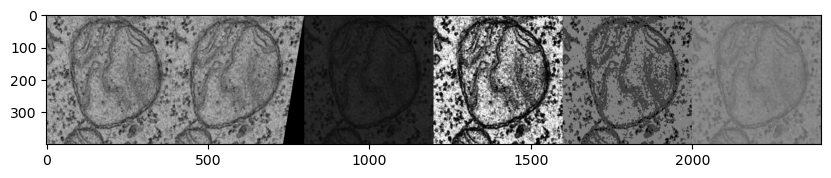

In [90]:
from torchvision.transforms import TrivialAugmentWide

augs = [TrivialAugmentWide()(cropped).squeeze() for _ in range(6)]
plt.imshow(np.concatenate(augs, axis=1), cmap='gray');